In [48]:
import implicit
import numpy as np
import pandas as pd

from implicit import evaluation
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from matplotlib import pyplot as plt
from scipy import sparse

import tqdm as notebook_tqdm

In [2]:
# Set a larger value for max_colwidth to avoid clipping of text in the final column
pd.set_option('max_colwidth', 500)

# Recommending Achievements to Steam Game Players

In this notebook, we compare recommender system approaches for determining the suitability of in-game achievements to players of a particular game. Since achievements can only be unlocked once, the interaction matrix between players and achievements consists of 0 and 1, and we treat the scenario as an implicit user feedback recommendation problem. For this reason, models and libraries such as <a href="https://surprise.readthedocs.io/en/stable/index.html">Surprise</a> which are designed exclusively for use with explicit ratings data are unsuitable and out of scope.

Unlike similar scenarios such as recommending movies based on a record of the movies a user has already watched, we can't assume _intent_: a player may unlock achievements which are part of a linear games' main storyline, or stumble across (sometimes deliberately hidden) achievements by accident.

### Dataset Assembly

We consider collections of players of `Grand Theft Auto 5`, `Cyberpunk 2077` and `Buldar's Gate 3`.

In [3]:
# Retrieve data describing all possible achievements
df_achievements = pd.read_csv('./data/buldars_gate_3_achievements_2023-11-04.csv')
df_achievements.head()

,name,defaultvalue,displayName,hidden,description,icon,icongray,player_count
0,BG3_Quest01,0,Descent From Avernus,0,Take control of the nautiloid and escape the Hells.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0cb31fd9ec036550a374aa702a37464a98da3bfa.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0950821dd57b97eb5ce309530dd61f0e3f2e3a6d.jpg,2568
1,BG3_Quest02,0,The Plot Thickens,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/628cdbbfd2e731735e4817252ce6633bf3bcd8ed.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/4127925c4aeb79134a98de629e7918ceb776b4fb.jpg,2104
2,BG3_Quest03,0,The City Awaits,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/3c6d05ff648b66925238963a658ee307e31ff870.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/092cc30e865fbb0158afe43fb343d6362e9292fa.jpg,1717
3,BG3_Quest04,0,All's Well That Ends Well,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/ecd435323119579216ebcffebae690ae2e5c13eb.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/c4307d65a1d8c9776f71e73494248b546e4135d8.jpg,1031
4,BG3_Quest05,0,Absolute Power Corrupts,1,NaN,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/265327d387174ee2160946bcde392352ce635b88.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/749d41e10cac54dbeb2b377d8bc69b2afdfbae62.jpg,253


What proportion of the achievements registered in the game schema actually have descriptions?

In [4]:
print(f"{df_achievements['description'].notna().mean() * 100:.1f}% of achievements come with descriptions.")

45.3% of achievements come with descriptions.


In [5]:
# Retrieve data describing players' achievements
df_players = pd.read_csv('./data/buldars_gate_3_players_2023-11-04.csv')
df_players

,steam_id,BG3_Quest01,BG3_Quest02,BG3_Quest03,BG3_Quest04,BG3_Quest05,BG3_Quest06,BG3_Quest07,BG3_Quest08,BG3_Quest09,...,BG3_Quest44,BG3_Quest45,BG3_Quest46,BG3_Quest47,BG3_Quest48,BG3_Quest49,BG3_Quest50,BG3_Quest51,BG3_Quest52,BG3_Quest53
0,76561199004154858,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,76561199058333673,1,1,1,1,0,1,0,0,1,...,0,0,0,1,0,0,1,1,0,0
2,76561198016380377,1,1,1,1,0,1,0,0,1,...,0,1,1,0,1,0,1,1,0,0
3,76561198898124688,1,1,1,0,0,0,0,0,1,...,0,1,1,1,0,0,1,1,0,0
4,76561198011137973,1,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,76561198137518354,1,1,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,1,0,0
2598,76561198115832615,1,1,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,0,0,0
2599,76561198056016073,1,1,1,1,0,1,0,1,1,...,0,0,1,1,0,1,1,1,0,0
2600,76561198137532719,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# Read in selected player statistics (number of games owned, playtime_forever for selected game)
df_play_stats = pd.read_csv('./data/buldars_gate_3_play_stats_2023-11-04.csv')
df_play_stats

,steamid,num_games_owned,playtime_forever
0,76561199004154858,290,5567
1,76561199058333673,120,4204
2,76561198016380377,218,9200
3,76561198898124688,47,13942
4,76561198011137973,289,11385
...,...,...,...
2597,76561198137518354,310,9125
2598,76561198115832615,136,30767
2599,76561198056016073,541,9453
2600,76561198137532719,50,5728


What does the completion of achievements look like amongst this set of players?

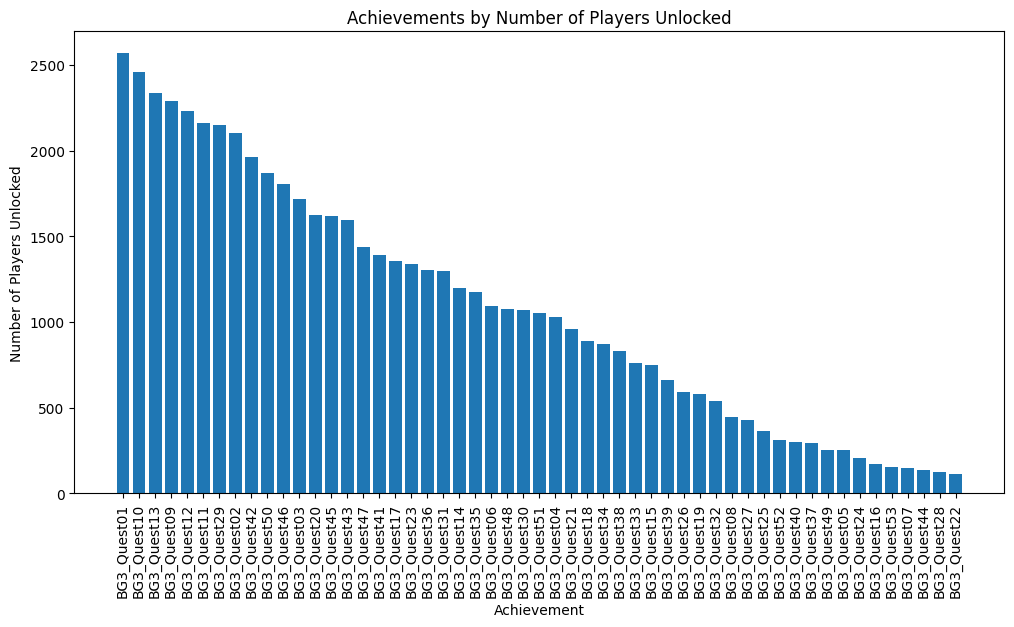

In [7]:
achievement_counts = (
    df_achievements[['name', 'player_count']]
    .rename(columns={'name': 'Achievement', 'player_count': 'Count'})
    .sort_values(by='Count', ascending=False)
)

# Plot a chart of player counts for achievements in descending order
plt.figure(figsize=(12, 6))
plt.bar(achievement_counts['Achievement'], achievement_counts['Count'])
plt.xlabel('Achievement')
plt.ylabel('Number of Players Unlocked')
plt.title('Achievements by Number of Players Unlocked')
plt.xticks(rotation=90)
plt.show()

In [8]:
# Top 5 most unlocked achievements
df_achievements.sort_values(by='player_count', ascending=False).head(5)

,name,defaultvalue,displayName,hidden,description,icon,icongray,player_count
0,BG3_Quest01,0,Descent From Avernus,0,Take control of the nautiloid and escape the Hells.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0cb31fd9ec036550a374aa702a37464a98da3bfa.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0950821dd57b97eb5ce309530dd61f0e3f2e3a6d.jpg,2568
9,BG3_Quest10,0,Bedrolls and Breakfast,0,Take four full Long Rests in a single playthrough - adventuring's tiring work.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/47daa8cf213809978d0f2ba9b514942c864ce452.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/042a397825694c4147bf6fc9bd580890b71573e7.jpg,2458
12,BG3_Quest13,0,No Penny Required,0,Successfully use Detect Thoughts to pry into someone's thoughts.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/c77588e8a25741098ac71ae64f4b08d84e357310.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/b2c45774e06a96ac4c091aa6525d1f3b389c499c.jpg,2336
8,BG3_Quest09,0,Roleplayer,0,Complete ten background goals in a single playthrough - you are one with your character.,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/9c1231f530788d9aa21e1a858fbb9e85e0cb64f8.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/6b55d2fb4ef8fbf7fe7605b561b95a762ea74ded.jpg,2289
11,BG3_Quest12,0,Dig for Victory,0,Dig up five buried chests in a single playthrough - treasure!,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/0dfd51a7ae1c5e122d1b46051d23234f5c5f681d.jpg,https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1086940/6ed09414918b95892c3c26558c800de7e79de03c.jpg,2230


In [9]:
# Create a lookup dictionary of steam_ids and achievement apinames for use with Implicit and LightFM
player_dict = dict(
    zip(
        df_players['steam_id'], 
        df_players.index
    )
)

achievement_dict = dict(
    zip(
        range(len(df_players.columns.drop('steam_id'))),
        df_players.columns.drop('steam_id').values
    )
)

In [10]:
def get_recommended_achievement_descriptions(scores, achievements):
    """
    Creates a table displaying the descriptions for the achievements in a
    set of achievement scores.
    Takes:
    - scores - a Pandas series of recommended achievement scores, indexed by apiname
    - achievements - a Pandas Dataframe with columns for API name and description
    Returns:
    - a table showing descriptions for each recommendation
    """
    scores.name = 'score'
    recommended_achievements = pd.merge(scores, achievements, left_index=True, right_on='name')
    recommended_achievements.set_index('name', inplace=True)
    recommended_achievements = recommended_achievements[['score', 'description']]

    return recommended_achievements

def display_recommended_achievements(player_of_interest, scores, known_achievements, recommended_achievements):
    """
    Displays the player's steam ID, descriptions of known achievements, and recommended achievements.
    Takes:
    - player_of_interest = Steam ID of the player of interest
    - scores = a Series of all scores
    - known_achievements = a list of apinames of the player's known achievements
    - recommended_achievements = a Series of scores, minus the known achievements
    """
    print(f"Player Steam ID: {player_of_interest}")
    print("Known achievements:")
    display(df_achievements[df_achievements['name'].isin(known_achievements)][['name', 'description']])
    print("Top 5 recommendations:")
    display(get_recommended_achievement_descriptions(recommended_achievements, df_achievements)[:5])
    print(f"Precision at k=10 score: {player_precision_at_k(scores, known_achievements, k=10)}")

def sample_recommendation_player_implicit(model, df, steam_id, player_dict, achievement_dict, show=False):
    """
    Function for producing user recommendations.
    Takes:
    - model = a trained Implicit model
    - df = a DataFrame describing the achievements of players. Has column
    for steam_id and a binary column for each achievement in the game
    - steam_id = the steam id of the player to produce recommendations for
    - player_dict = dictionary mapping steam_ids to the internal id used by Implicit
    - achievement_dict = dictionary mapping achievement internal id to apinames
    user by Implicit
    Returns:
    - scores - a Series of all scores
    - known_items - a list of the apinames of known achievements of the player
    - recommended_items - a Series of scores, minus the known achievements
    """
    known_player_achievements = sparse.csr_matrix(
        df[df['steam_id'] == steam_id]
        .drop(columns=['steam_id'])
        .values
        .astype(np.float32))
    ids, scores = model.recommend(
        player_dict[steam_id], 
        known_player_achievements, 
        N=len(achievement_dict.keys()), 
        filter_already_liked_items=False)
    scores = pd.Series(scores, index=ids).sort_index()
    scores.index = scores.index.map(achievement_dict)
    scores = scores.sort_values(ascending=False)
    player_row = df[df['steam_id'] == steam_id]
    known_items = player_row.columns[player_row.iloc[0] == 1].tolist()
    recommended_items = scores.drop(known_items)

    if show:
        display_recommended_achievements(steam_id, scores, known_items, recommended_items)

    return scores, known_items, recommended_items

def sample_recommendation_player_lightfm(model, df, steam_id, player_dict, achievement_dict, show=False):
    """
    Function for producing user recommendations.
    Takes:
    - model = a trained LightFM model
    - df = a DataFrame describing the achievements of players. Has column
    for steam_id and a binary column for each achievement in the game
    - steam_id = the steam id of the player to produce recommendations for
    - player_dict = dictionary mapping steam_ids to the internal id used by LightFM
    - achievement_dict = dictionary mapping achievement internal id to apinames
    user by LightFM
    Returns:
    - scores - a Series of all scores
    - known_items - a list of the apinames of known achievements of the player
    - recommended_items - a Series of scores, minus the known achievements
    """
    scores = pd.Series(
        model.predict(
            player_dict[steam_id], 
            [key for key in achievement_dict.keys()]
        )
    )
    scores.index = achievement_dict.values()
    scores = scores.sort_values(ascending=False)
    player_row = df[df['steam_id'] == steam_id]
    known_items = player_row.columns[player_row.iloc[0] == 1].tolist()
    recommended_items = scores.drop(known_items)

    if show:
        display_recommended_achievements(steam_id, scores, known_items, recommended_items)

    return scores, known_items, recommended_items

def player_precision_at_k(scores, known_items, k=10):
    """
    Calculates the precision_at_k metric for a single player.
    Takes:
    - scores = a Series of recommendation scores, indexed by apiname
    - known_items = a list of the apiname of known achievements for the player
    Returns:
    - precision_at_k = the fraction of known positives in the first k positions
    of the ranked list of scores
    """
    top_k_scores = scores.sort_values(ascending=False).head(k)
    precision_at_k = len(set(known_items).intersection(top_k_scores.index)) / k
    
    return precision_at_k

def get_implicit_model_evaluation(model, train, test, K=10, show=False):
    """
    Evaluates the given model using precision_at_k and AUC_at_k methods. 
    Optionally prints the evaluation.
    Takes:
    - model = a trained implicit model
    - train = the numpy sparse coo_matrix that the model was trained on
    - test = the numpy sparse coo_matrix of the test data
    - K = the number of top recommendations to consider for evaluation
    - show = Boolean indication whether the evaluation should be printed
    Returns:
    - a tuple of precision_at_k, AUC_at_k
    """
    precision = evaluation.precision_at_k(model, train.astype(np.float32), test.astype(np.float32), K)
    auc = evaluation.AUC_at_k(model, train.astype(np.float32), test.astype(np.float32), K)
    ndcg = evaluation.ndcg_at_k(model, train.astype(np.float32), test.astype(np.float32), K)

    if show:
        print("Precision: %.2f." % (precision))
        print("AUC: %.2f" % (auc))
        print("NDCG: %.2f" % (ndcg))
        
    return precision, auc, ndcg


Many recommender systems suffer from popularity bias, where they emphasise items with more interactions over other 'long-tail' items.

Following the approach in <a href="https://arxiv.org/pdf/1901.07555.pdf">https://arxiv.org/pdf/1901.07555.pdf</a>, we define functions for measuring how much a model recommends achievements from the long tail, defined as the 80% least-commonly occurring achievements in the training dataset. 

We consider the metric:

<b>Average Percentage of Long Tail Items (APLT)</b><br>
The average percentage of long tail items in the top K=10 of the recommended achievement lists

In [11]:
def average_proportion_long_tail_at_k(model, df, K=10, filter_already_liked_items=True):
    """
    Calculates the average proportion of the top K achievements recommended
    by the model to each player which appear in the popularity long tail (bottom 20%).
    Takes:
    - model = a trained implicit model
    - df = a Pandas DataFrame with columns for Steam ID and player interactions with each achievement
    - K = the number of top recommendations to consider
    - filter_already_liked_items = whether to filter achievements that the player has already
    interacted with from recommendations when calculating the proportion 
    Returns: 
    The average proportion of top K recommendations which appear in the long tail
    """
    # Get the achievement indices of the long tail
    achievement_popularities = df.drop(columns=['steam_id']).sum(axis=0)
    achievement_popularities.index = range(len(achievement_popularities.index))
    achievement_popularities = achievement_popularities.sort_values(ascending=False)
    long_tail = achievement_popularities.iloc[int(len(achievement_popularities) * 0.2):].index.to_numpy()

    # Get the indices for the recommended achievements
    inds, _ = model.recommend(
        [x for x in range(df.shape[0])], 
        sparse.csr_matrix(
            df.drop(columns=['steam_id'])
            .values
            .astype(np.float32)
        ), 
        N=K, 
        filter_already_liked_items=filter_already_liked_items
    )

    # Convert the lists in test_inds to NumPy arrays
    inds_arrays = [np.array(lst) for lst in inds]

    # Create a boolean mask for common elements
    common_elements_mask = np.isin(inds_arrays, long_tail)
    proportions = common_elements_mask.sum(axis=1) / np.array([len(lst) for lst in inds])
    
    return proportions.mean()


In [12]:
# Implicit and LightFM both require the data to be a numpy sparse coo_matrix (COOrdinate format)
# Randomly assign 20% of all interaction pairs to the test set
train, test = random_train_test_split(
    sparse.coo_matrix(df_players.drop(columns=['steam_id'])), 
    test_percentage=0.2,
    random_state=42 
)

### Implicit Nearest Neighbour Models

We compare the performance of several models from the <a href="https://benfred.github.io/implicit/api/models/cpu/als.html">Implicit</a> library's family of item-item nearest neighbour models.

#### Cosine Recommender
Train an item-item recommender based on the cosine distances between items.

In [13]:
model_implicit_cosine = implicit.nearest_neighbours.CosineRecommender(K=20) # Use K=20 items in the neighbourhood
model_implicit_cosine.fit(train)

/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0022649765014648438 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 1128.29it/s]


In [14]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the cosine distance model
precision_implicit_cosine, auc_implicit_cosine, ndcg_implicit_cosine = get_implicit_model_evaluation(model_implicit_cosine, train, test, show=True)

  0%|          | 0/2428 [00:00<?, ?it/s]

100%|██████████| 2428/2428 [00:00<00:00, 20920.08it/s]

Precision: 0.80.
AUC: 0.87
NDCG: 0.75


#### TFIDF Recommender

Train a recommender using TF-IDF distances between achievements.

In [15]:
model_implicit_tfidf = implicit.nearest_neighbours.TFIDFRecommender(K=20)
model_implicit_tfidf.fit(train)

/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0014119148254394531 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 1525.44it/s]


In [16]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the TF-IDF distance model
precision_implicit_tfidf, auc_implicit_tfidf, ndcg_implicit_tfidf = get_implicit_model_evaluation(model_implicit_tfidf, train, test, show=True)

# Calculate the proportion of top 10 recommended items which belong to the popularity "long tail"
aplt_at_k_tfidf = average_proportion_long_tail_at_k(model_implicit_tfidf, df_players, K=10, filter_already_liked_items=False)
print(f"Average Percentage of Long Tail Items: {aplt_at_k_tfidf * 100 :.1f}%")

  0%|          | 0/2428 [00:00<?, ?it/s]

100%|██████████| 2428/2428 [00:00<00:00, 17496.17it/s]


Precision: 0.81.
AUC: 0.88
NDCG: 0.75
Average Percentage of Long Tail Items: 30.4%


The TF-IDF distance recommender, on average, pulls about 30% of the top 10 recommendations for the player from the "long tail" of popular achievements.

#### BM25 Recommender

Train a model using the BM25 distance between achievements.

In [17]:
model_implicit_bm25 = implicit.nearest_neighbours.BM25Recommender(K=20)
model_implicit_bm25.fit(train)

/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0019385814666748047 seconds
  warnings.warn(
100%|██████████| 53/53 [00:00<00:00, 1838.15it/s]


In [18]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the BM25 distance model
precision_implicit_bm25, auc_implicit_bm25, ndcg_implcit_bm25 = get_implicit_model_evaluation(model_implicit_bm25, train, test, show=True)

  0%|          | 0/2428 [00:00<?, ?it/s]

100%|██████████| 2428/2428 [00:00<00:00, 19605.93it/s]

Precision: 0.79.
AUC: 0.87
NDCG: 0.77


We retrieve recommendations for a given player using Implicit's TF-IDF similarity recommender:

In [19]:
# Get known achievements and recommended achievements for first player using Implicit cosine
player_of_interest = df_players['steam_id'][0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_implicit(
    model_implicit_tfidf, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest09,5.954372,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest12,5.809872,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest02,5.492703,NaN
BG3_Quest46,5.146382,NaN
BG3_Quest20,4.833409,NaN


Precision at k=10 score: 0.7


### Implicit Matrix Factorization Models

We attempt to fit several of the models from Implicit's family of Matrix Factorization models.

####  Alternating Least Squares
We evaluate the performance of Implicit's Alternating Least Squares model.

In [20]:
# Initialise an Implicit ALS model
model_implicit_als = implicit.als.AlternatingLeastSquares(random_state=42)
model_implicit_als.fit(train);

/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0017757415771484375 seconds
  warnings.warn(
  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


In [21]:
# Get the precision_at_k AUC_at_k and NDCG_at_k for the ALS model
precision_implicit_als, auc_implicit_als, ndcg_implicit_als  = get_implicit_model_evaluation(model_implicit_als, train, test, show=True)

  0%|          | 0/2428 [00:00<?, ?it/s]

100%|██████████| 2428/2428 [00:00<00:00, 6273.01it/s]

Precision: 0.49.
AUC: 0.65
NDCG: 0.37


In [22]:
# Get known achievements and recommended achievements for first player using Implicit ALS
player_of_interest = df_players['steam_id'][0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_implicit(
    model_implicit_als, df_players, player_of_interest, player_dict, achievement_dict, show=True)


Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest19,0.002169,NaN
BG3_Quest39,0.001661,NaN
BG3_Quest15,0.001614,Recruit a hireling. You can befriend them or use them as cannon-fodder - we won't judge.
BG3_Quest07,0.001560,NaN
BG3_Quest37,0.001511,Defeat Gortash in Wyrm's Rock without activating any traps.


Precision at k=10 score: 0.8


#### Logistic Matrix Factorization

We evaluate the performance of Implicit's Alternating Least Squares model.

In [23]:
# Initialise an Implicit Logistic Matrix Factorization model
model_implicit_lmf = implicit.lmf.LogisticMatrixFactorization(random_state=42)
model_implicit_lmf.fit(train);

/home/rich/anaconda3/envs/pydata/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0005047321319580078 seconds
  warnings.warn(
  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 199.65it/s]


In [24]:
# Get the precision_at_k, AUC_at_k and NDCG_at_k for the LMF model
precision_implicit_lmf, auc_implicit_lmf, ndcg_implicit_lmf = get_implicit_model_evaluation(model_implicit_lmf, train, test, show=True)

  0%|          | 0/2428 [00:00<?, ?it/s]

100%|██████████| 2428/2428 [00:00<00:00, 14140.55it/s]

Precision: 0.50.
AUC: 0.66
NDCG: 0.35


### Light FM
We train models from those available from <a href="https://making.lyst.com/lightfm/docs/home.html">LightFM</a> (paper available on <a href="https://arxiv.org/pdf/1507.08439.pdf">arxiv</a>).<br>
If we don't pass in any feature representations for players or achievements, LightFM reduces to a traditional collaborative filtering matrix factorization method.

In [25]:
def prepare_player_features(features):
    """
    Prepare player features for use with LightFM.
    Takes:
    - features = a DataFrame with columns for steam id and player features.
    Returns:
    - an np.float32 csr matrix of shape [n_players, n_player_features]
    """
    return sparse.csr_matrix(
        features
        .drop(columns=['steamid'])
        .values
        .astype(np.float32)
    )

In [26]:
player_features = prepare_player_features(df_play_stats)

#### Bayesian Personalised Ranking pairwise loss (BPR)

Maximises the prediction difference between a positive example and a randomly chosen negative example. Otimises the ROC AUC metric.

In [27]:
# Train LightFM BPR model
model_lightfm_bpr = LightFM(learning_rate=0.05, loss='bpr', random_state=42)
# BPR: Bayesian Personalised Ranking pairwise loss. 
# Maximises the prediction difference between a positive example 
# and a randomly chosen negative example. 
# Useful when only positive interactions are present and optimising ROC AUC is desired.
model_lightfm_bpr.fit(train);

In [28]:
# The proportion of known positives that are within the first k results on the 
# list or recommendations
train_precision_bpr = precision_at_k(model_lightfm_bpr, train, k=10).mean()
test_precision_bpr = precision_at_k(model_lightfm_bpr, test, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_bpr = auc_score(model_lightfm_bpr, train).mean()
test_auc_bpr = auc_score(model_lightfm_bpr, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_bpr, test_precision_bpr))
print('AUC: train %.2f, test %.2f.' % (train_auc_bpr, test_auc_bpr))

Precision: train 0.68, test 0.18.
AUC: train 0.82, test 0.73.


In [29]:
# Get known achievements and recommended achievements for first player
player_of_interest = df_players['steam_id'][0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_lightfm(
    model_lightfm_bpr, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest02,0.505724,NaN
BG3_Quest09,0.499489,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest12,0.409539,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest46,0.278606,NaN
BG3_Quest20,0.150558,NaN


Precision at k=10 score: 0.6


#### Weighted Approximate-Rank Pairwise loss (WARP)

In [30]:
# Train LightFM WARP model
model_lightfm_warp = LightFM(learning_rate=0.05, loss='warp', random_state=42)
# WARP: Weighted Approximate-Rank Pairwise loss. 
# Maximises the rank of positive examples by repeatedly sampling negative examples 
# until rank violating one is found. 
# Useful when only positive interactions are present and optimising 
# the top of the recommendation list (precision_at_k) is desired.
model_lightfm_warp.fit(train);

In [31]:
# The proportion of known positives that are within the first k results on the 
# list or recommendations
train_precision_warp = precision_at_k(model_lightfm_warp, train, k=10).mean()
test_precision_warp = precision_at_k(model_lightfm_warp, test, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp = auc_score(model_lightfm_warp, train).mean()
test_auc_warp = auc_score(model_lightfm_warp, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp, test_precision_warp))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp, test_auc_warp))

Precision: train 0.69, test 0.18.
AUC: train 0.85, test 0.73.


In [32]:
# Get known achievements and recommended achievements for first player
player_of_interest = df_players['steam_id'][0]
scores, known_achievements, recommended_achievements = sample_recommendation_player_lightfm(
    model_lightfm_warp, df_players, player_of_interest, player_dict, achievement_dict, show=True)

Player Steam ID: 76561199004154858
Known achievements:


,name,description
0,BG3_Quest01,Take control of the nautiloid and escape the Hells.
9,BG3_Quest10,Take four full Long Rests in a single playthrough - adventuring's tiring work.
10,BG3_Quest11,NaN
12,BG3_Quest13,Successfully use Detect Thoughts to pry into someone's thoughts.
28,BG3_Quest29,Perform five attacks in one turn. Your enemies won't know what hit them (literally).
29,BG3_Quest30,Kill a character with an Unarmed Strike.
30,BG3_Quest31,Defeat Commander Zhalk on the nautiloid.
31,BG3_Quest32,NaN
41,BG3_Quest42,Kill a creature with falling damage.
44,BG3_Quest45,Play fetch with Scratch - the best boy in the Realms.


Top 5 recommendations:


,score,description
name,,
BG3_Quest09,1.126111,Complete ten background goals in a single playthrough - you are one with your character.
BG3_Quest02,0.997929,NaN
BG3_Quest12,0.908207,Dig up five buried chests in a single playthrough - treasure!
BG3_Quest46,0.603169,NaN
BG3_Quest20,0.470632,NaN


Precision at k=10 score: 0.6


We fit a WARP loss model with user features in order to train a "hybrid" model:

In [33]:
model_lightfm_warp_hybrid = LightFM(learning_rate=0.05, loss='warp', random_state=42)
model_lightfm_warp_hybrid.fit(train, player_features);


In [34]:
train_precision_warp_hybrid = precision_at_k(model_lightfm_warp_hybrid, train, user_features=player_features, k=10).mean()
test_precision_warp_hybrid = precision_at_k(model_lightfm_warp_hybrid, test, user_features=player_features, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp_hybrid = auc_score(model_lightfm_warp_hybrid, train, user_features=player_features).mean()
test_auc_warp_hybrid = auc_score(model_lightfm_warp_hybrid, test, user_features=player_features).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp_hybrid, test_precision_warp_hybrid))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp_hybrid, test_auc_warp_hybrid))

Precision: train 0.24, test 0.06.
AUC: train 0.53, test 0.53.


We can use a vector representation of each player which consists of the total playtime (in minutes) attributed to each genre that they play:

In [42]:
# Read in the playtimes attributes to each genre for each player
df_genre_playtimes = pd.read_csv('./data/buldars_gate_3_player_genre_playtimes_2023-07-04.csv').rename(columns={'steam_id': 'steamid'})
df_genre_playtimes

,steamid,action,rpg,adventure,casual,simulation,strategy,indie,free to play,massively multiplayer,...,photo editing,utilities,video production,game development,audio production,education,web publishing,software training,movie,accounting
0,76561199004154858,284719,139819,111869,4658,145470,188425,73581,61985,13944,...,358,358,0,0,0,0,0,0,0,0
1,76561199058333673,21094,6021,23339,1251,782,6846,4261,3010,2621,...,329,329,0,0,0,0,0,0,0,0
2,76561198016380377,114234,138309,153019,87191,108409,124549,131727,76426,47784,...,732,4214,0,0,0,0,0,0,0,0
3,76561198898124688,169319,116134,92346,11562,8312,20518,29027,1667,18750,...,875,875,14,0,0,0,0,0,0,0
4,76561198011137973,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,76561198137518354,393132,343848,222596,21058,86424,180815,162705,111029,114093,...,1708,1708,0,2210,7,2210,2210,7,0,0
2598,76561198115832615,343959,458307,407367,24989,77171,190699,328191,37815,100910,...,0,0,0,0,0,0,0,0,0,0
2599,76561198056016073,461428,130835,180911,23759,35844,47386,86340,120395,12038,...,1257,1257,5903,0,0,1454,0,1454,0,0
2600,76561198137532719,37940,29016,12050,119459,185612,186959,150269,2076,188,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Convert the player genre playtimes into csr matrixes suitable for use with LightFM:
player_features_genre = prepare_player_features(df_genre_playtimes)

In [46]:
model_lightfm_warp_hybrid_genre_playtimes = LightFM(learning_rate=0.05, loss='warp', random_state=42)
model_lightfm_warp_hybrid_genre_playtimes.fit(train, player_features_genre);

In [47]:
train_precision_warp_hybrid_genre_playtimes = precision_at_k(model_lightfm_warp_hybrid_genre_playtimes, train, user_features=player_features_genre, k=10).mean()
test_precision_warp_hybrid_genre_playtimes = precision_at_k(model_lightfm_warp_hybrid_genre_playtimes, test, user_features=player_features_genre, k=10).mean()

# Probability that any known positive is higher on the recommendations list
# than a random negative example
train_auc_warp_hybrid_genre_playtimes= auc_score(model_lightfm_warp_hybrid_genre_playtimes, train, user_features=player_features_genre).mean()
test_auc_warp_hybrid_genre_playtimes = auc_score(model_lightfm_warp_hybrid_genre_playtimes, test, user_features=player_features_genre).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision_warp_hybrid_genre_playtimes, test_precision_warp_hybrid_genre_playtimes))
print('AUC: train %.2f, test %.2f.' % (train_auc_warp_hybrid_genre_playtimes, test_auc_warp_hybrid_genre_playtimes))

Precision: train 0.38, test 0.10.
AUC: train 0.56, test 0.54.
